# Drift Simulator

## User Specifications

In [1]:
### User can change these variables (unless they begin with an underscore) ###

drift_model = 'wagner'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'

iip_season = 2015  # must be 2015 (more to come later)
iip_indices = range(3284, 3286)  # iip_indices must be list or range

## Imports

In [2]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc

In [3]:
if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from icedef.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [4]:
iip_df = iceberg.add_datetime_column(iceberg.get_iip_df(iip_season))
iip_berg_df = iceberg.get_iip_berg_df(iip_df, indices=iip_indices)
iip_berg_df

/home/evankielley/IceDEF/icedef/iceberg.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.hour, unit='h')
/home/evankielley/IceDEF/icedef/iceberg.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.minute, unit='m')


,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,3284,2015,20668,6/17/2015,1043,48.16,-50.16,R/V,LG,GEN,GMRS,2015-06-17 10:43:00
1,3285,2015,20668,6/18/2015,1251,48.17,-49.91,VIS,LG,TAB,GTJZ,2015-06-18 12:51:00


In [5]:
iip_berg = iceberg.get_iip_berg(iip_berg_df)

## Metocean Data

In [6]:
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['20150617.nc', '20150618.nc']

In [7]:
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['20150617.nc', '20150618.nc']

## Simulate Drift

In [8]:
# Timesteps
t_step_hours = 0.5

t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

# Model iceberg
mod_berg = iceberg.clone_iceberg_state(iip_berg)
    
    
# Constants
earth_radius = 6378*1e3  # radius of Earth  (m)


# Buffer number for bounding spatial box
drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))


for t in t_all:

    mod_berg.T = t

    # Wind and ocean current velocities
    T_ocean = nc.date2num(mod_berg.T, ocean_data.t_units, ocean_data.t_calendar)
    T_atm = nc.date2num(mod_berg.T, atm_data.t_units, atm_data.t_calendar)
    Vcx = ocean_data.iUW([T_ocean, mod_berg.Y, mod_berg.X])[0]  # u-component of ocean current velocity (m/s)
    Vcy = ocean_data.iVW([T_ocean, mod_berg.Y, mod_berg.X])[0]  # v-component of ocean current velocity (m/s)
    Vax = atm_data.iUA([T_atm, mod_berg.Y, mod_berg.X])[0]  # u-component of air velocity (m/s)
    Vay = atm_data.iVA([T_atm, mod_berg.Y, mod_berg.X])[0]  # v-component of air velocity (m/s)

    # Drift
    mod_berg.Vx, mod_berg.Vy = drift(mod_berg, Vax, Vay, Vcx, Vcy, dt)

    # Iceberg position (note the conversion from meters back to degrees)
    y_ = mod_berg.Y
    # y-component of iceberg position (degrees latitude)
    mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))
    # x-component of iceberg position (degrees longitude)
    mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))

    if not drift_xmin < mod_berg.X < drift_xmax:
        print('Iceberg out-of-bounds')
        break

    elif not drift_ymin < mod_berg.Y < drift_ymax:
        print('Iceberg out-of-bounds')
        break

    else:
        mod_berg.history['T'].append(mod_berg.T)
        mod_berg.history['X'].append(mod_berg.X)
        mod_berg.history['Y'].append(mod_berg.Y)
        mod_berg.history['Vx'].append(mod_berg.Vx)
        mod_berg.history['Vy'].append(mod_berg.Vy)

print("Final time: {}".format(t)) 

Final time: 2015-06-18 13:13:00


## Plotting

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


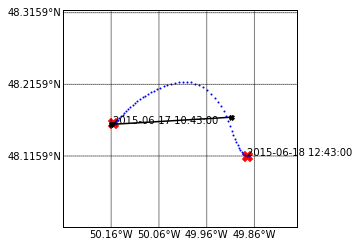

In [9]:
plot.plot_drift_track_test_case(iip_berg, mod_berg)

# Varying parameters

In [11]:
from scipy.stats import truncnorm

In [12]:
def get_data_subset(data, xy_res, lats, lons, min_lat, max_lat, min_lon, max_lon):
    
    min_lat_idx = min(np.where(abs(lats - min_lat) < xy_res)[0])
    max_lat_idx = max(np.where(abs(lats - max_lat) < xy_res)[0])
    min_lon_idx = min(np.where(abs(lons - min_lon) < xy_res)[0])
    max_lon_idx = max(np.where(abs(lons - max_lon) < xy_res)[0])
    
    data_subset = data[:, min_lat_idx:max_lat_idx+1, min_lon_idx:max_lon_idx+1]
    
    return data_subset

def get_data_stats(data):
    
    data_mean = np.mean(data.flatten())
    data_std = np.std(data.flatten())

    return data_mean, data_std

def vary_current(data):
    
    data_mean, data_std = get_data_stats(data)
    data_sample = truncnorm.rvs(-1,1, loc=data_mean, scale=data_std)
    data_offset = data_mean - data_sample
    
    return data_offset

def vary_wind(data):
    
    data_mean, data_std = get_data_stats(data)
    data_sample = truncnorm.rvs(-20,20, loc=data_mean, scale=data_std)
    data_offset = data_mean - data_sample
    
    return data_offset

In [13]:
def vary_drag_coefficient():
    return np.random.uniform(0.5,2.5)

In [14]:
# Ocean data
UW_data_subset = get_data_subset(ocean_data.UW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))
VW_data_subset = get_data_subset(ocean_data.VW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))

# Atmospheric data
UA_data_subset = get_data_subset(atm_data.UA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))
VA_data_subset = get_data_subset(atm_data.VA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))

In [15]:
print(vary_current(UW_data_subset))
print(vary_current(VW_data_subset))
print(vary_wind(UA_data_subset))
print(vary_wind(VA_data_subset))

-0.0499547555472
0.0564122956802
6.98821497648
1.34828445742
